### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence. 

The shuffling of the dataframe was making a difference to whether the model would get started learning or not - with a shuffled dataset, I needed a lower learning rate. 

During training, there are the same number of positive classes as absent classes. This is true of the validation set used during training too. The full unbalanced validation set contains far more absence than presence, and hence the number of false positives is much higher in the full validation set than in the balanced one. 


I can now check the effect of cleaning the dataset. 

In [86]:
description = "Train with focal samples"

In [87]:
# !pip install wandb
# ! pip install wandb --upgrade

In [88]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [89]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [91]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [294]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import torch
from utils import plot_metrics_across_thresholds



In [93]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"


In [94]:
# df_train.sample()

# Set some hyperparameters

In [142]:
n_samples_per_class = 800
one_output_neuron = True
random_seed = 43
learning_rate = 0.002
epochs=10

In [143]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [144]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")


train_df.value_counts()

target_absence  target_presence
1.0             0.0                45081
0.0             1.0                 4211
Name: count, dtype: int64

# Load focal recordings and split into train and valid sets
This is done by location and in accordance with the original train valid split locations. 

In [145]:
focal_recs = pd.read_pickle(data_path / "interim" / "train_and_valid_set" /"focal_osfls_thresh_0.99_ngen_1038.pkl")

# Convert the focal df index to Path objects
new_index = focal_recs.index.set_levels(focal_recs.index.levels[0].map(Path), level=0)

# Split the focal clips into train and valid sets by filtering by the file paths at index of each dataset. 
focal_recs.index = new_index

train_df_file_paths = train_df.index.get_level_values('file')
valid_df_file_paths = valid_df.index.get_level_values('file')
focal_recs_file_paths = focal_recs.index.get_level_values('file')

train_focal_recs_idx = focal_recs_file_paths.isin(train_df_file_paths)
valid_focal_recs_idx = focal_recs_file_paths.isin(valid_df_file_paths)

train_focal = focal_recs[train_focal_recs_idx]
valid_focal = focal_recs[valid_focal_recs_idx]

Only 6% of the focal samples were found as the first vocalization by the human labeller. 

In [146]:
intersect = train_focal.index.isin(train_df.index)
sum(intersect) / len(train_focal)

0.059375

In [147]:
len(train_focal)

960

There are 4000 present samples and 45081 absent samples avaliable for training. 

We can test the effect of mixing in extra samples by either:
- completely replacing the training present samples with focal ones
- mixing them in in ratios

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [148]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2 7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [149]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45081
 1.0     4211
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [150]:
print(n_samples_per_class)

800


In [151]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

# Drop the rows from train df that are in balanced_train_df

# second_train_pool = train_df[~train_df.index.isin(balanced_train_df.index)]

# second_balanced_train_df = resample(second_train_pool,n_samples_per_class=n_samples_per_class,random_state=random_seed)



# # drop the redundant absence column
balanced_train_df = balanced_train_df.drop(columns=["target_absence"])
# second_balanced_train_df = second_balanced_train_df.drop(columns=["target_absence"])
balanced_valid_df = balanced_valid_df.drop(columns=["target_absence"])


balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    800
 1.0    800
 Name: count, dtype: int64,
 1600)

In [153]:
# # Find the overlap between balanced train df and second balanced train df
# overlap = balanced_train_df[balanced_train_df.index.isin(second_balanced_train_df.index)]
# overlap

In [182]:
# Combine the absent samples from train_df with the focal samples
absent = train_df.loc[train_df.target_absence == 1]
absent.drop(columns=["target_absence"], inplace=True)
focal_train["target_presence"] = 1.0
focal_train = focal_train[["target_presence"]]
focal_train_df = pd.concat([absent, focal_train])


AttributeError: 'DataFrame' object has no attribute 'target_absence'

In [197]:

shuffled_focal_train_df = train_df.sample(frac=1, random_state=random_seed)

In [184]:
balanced_train_df.head()

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-294795.mp3,25.5,28.5,0.0
../../data/raw/recordings/OSFL/recording-316188.mp3,31.5,34.5,0.0
../../data/raw/recordings/OSFL/recording-291910.mp3,19.5,22.5,0.0
../../data/raw/recordings/OSFL/recording-552598.flac,40.5,43.5,0.0
../../data/raw/recordings/OSFL/recording-817014.flac,40.5,43.5,0.0


In [185]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [186]:
idx=0

In [187]:
shuffled_balanced_train_df = balanced_train_df.sample(frac=1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1)

Present label: 1.0
Last clip: 232.5
../../data/raw/recordings/OSFL/recording-291555.mp3 255.0 258.0


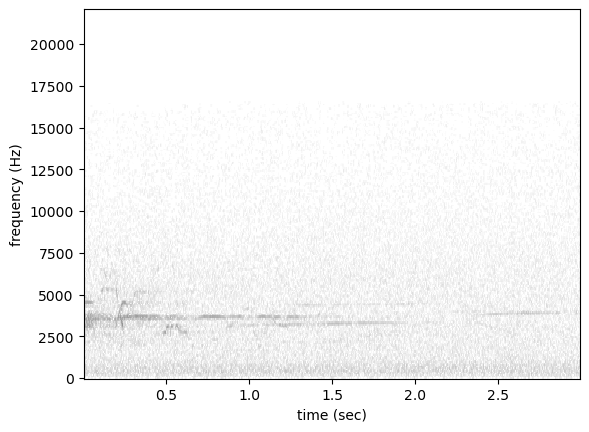

In [188]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [189]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

In [190]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

In [191]:
model.optimizer_params['lr'] = learning_rate


In [192]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [193]:
class_list

['target_presence']

In [194]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


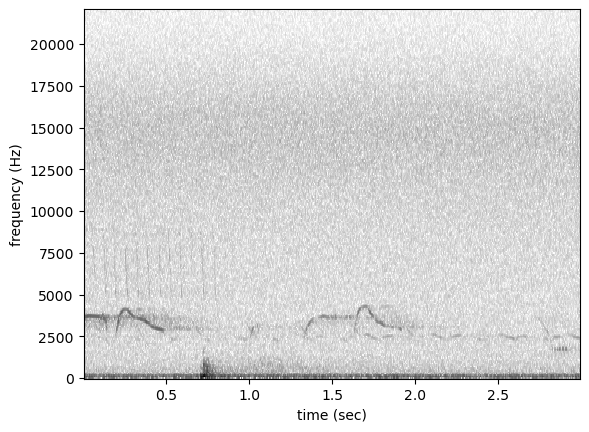

In [205]:
show_sample_from_df(present=True, df = shuffled_focal_train_df)


In [206]:
print(f'model.device is: {model.device}')

model.device is: mps


In [207]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [208]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [209]:
shuffled_balanced_valid_df.value_counts()

target_presence
0.0                500
1.0                500
Name: count, dtype: int64

In [211]:
# Loop 1 on the first balanced training set
model.train(
    shuffled_focal_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 0 [batch 0/721, 0.00%] 
	DistLoss: 0.395
Metrics:
Epoch: 0 [batch 100/721, 13.87%] 
	DistLoss: 0.104


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 0 [batch 200/721, 27.74%] 
	DistLoss: 0.080


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 0 [batch 300/721, 41.61%] 
	DistLoss: 0.069
Metrics:
Epoch: 0 [batch 400/721, 55.48%] 
	DistLoss: 0.060
Metrics:
Epoch: 0 [batch 500/721, 69.35%] 
	DistLoss: 0.055
Metrics:
Epoch: 0 [batch 600/721, 83.22%] 
	DistLoss: 0.051


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 0 [batch 700/721, 97.09%] 
	DistLoss: 0.047
Metrics:
Metrics:
	MAP: 0.705

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.791

Training Epoch 1


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 1 [batch 0/721, 0.00%] 
	DistLoss: 0.060


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 1 [batch 100/721, 13.87%] 
	DistLoss: 0.031
Metrics:
Epoch: 1 [batch 200/721, 27.74%] 
	DistLoss: 0.027
Metrics:
Epoch: 1 [batch 300/721, 41.61%] 
	DistLoss: 0.027
Metrics:
Epoch: 1 [batch 400/721, 55.48%] 
	DistLoss: 0.025
Metrics:
Epoch: 1 [batch 500/721, 69.35%] 
	DistLoss: 0.026
Metrics:
Epoch: 1 [batch 600/721, 83.22%] 
	DistLoss: 0.026
Metrics:
Epoch: 1 [batch 700/721, 97.09%] 
	DistLoss: 0.025


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Metrics:
	MAP: 0.884

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.817

Training Epoch 2


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 2 [batch 0/721, 0.00%] 
	DistLoss: 0.003


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 2 [batch 100/721, 13.87%] 
	DistLoss: 0.022
Metrics:
Epoch: 2 [batch 200/721, 27.74%] 
	DistLoss: 0.020
Metrics:
Epoch: 2 [batch 300/721, 41.61%] 
	DistLoss: 0.021
Metrics:
Epoch: 2 [batch 400/721, 55.48%] 
	DistLoss: 0.020
Metrics:
Epoch: 2 [batch 500/721, 69.35%] 
	DistLoss: 0.020
Metrics:
Epoch: 2 [batch 600/721, 83.22%] 
	DistLoss: 0.020
Metrics:
Epoch: 2 [batch 700/721, 97.09%] 
	DistLoss: 0.021
Metrics:
Metrics:
	MAP: 0.908

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.809

Training Epoch 3


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 3 [batch 0/721, 0.00%] 
	DistLoss: 0.055
Metrics:
Epoch: 3 [batch 100/721, 13.87%] 
	DistLoss: 0.017
Metrics:
Epoch: 3 [batch 200/721, 27.74%] 
	DistLoss: 0.021


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 3 [batch 300/721, 41.61%] 
	DistLoss: 0.020
Metrics:
Epoch: 3 [batch 400/721, 55.48%] 
	DistLoss: 0.020
Metrics:
Epoch: 3 [batch 500/721, 69.35%] 
	DistLoss: 0.019
Metrics:
Epoch: 3 [batch 600/721, 83.22%] 
	DistLoss: 0.020
Metrics:
Epoch: 3 [batch 700/721, 97.09%] 
	DistLoss: 0.019
Metrics:
Metrics:
	MAP: 0.922

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.835

Training Epoch 4


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 4 [batch 0/721, 0.00%] 
	DistLoss: 0.007
Metrics:
Epoch: 4 [batch 100/721, 13.87%] 
	DistLoss: 0.017
Metrics:
Epoch: 4 [batch 200/721, 27.74%] 
	DistLoss: 0.016
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch: 4 [batch 300/721, 41.61%] 
	DistLoss: 0.017
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch: 4 [batch 400/721, 55.48%] 
	DistLoss: 0.017
Metrics:
Epoch: 4 [batch 500/721, 69.35%] 
	DistLoss: 0.017
Metrics:
Epoch: 4 [batch 600/721, 83.22%] 
	DistLoss: 0.017
Metrics:
Epoch: 4 [batch 700/721, 97.09%] 
	DistLoss: 0.016
Metrics:
Metrics:
	MAP: 0.938

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.823

Training Epoch 5


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 5 [batch 0/721, 0.00%] 
	DistLoss: 0.006
Metrics:
Epoch: 5 [batch 100/721, 13.87%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 5 [batch 200/721, 27.74%] 
	DistLoss: 0.015
Metrics:
Epoch: 5 [batch 300/721, 41.61%] 
	DistLoss: 0.016


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 5 [batch 400/721, 55.48%] 
	DistLoss: 0.015
Metrics:
Epoch: 5 [batch 500/721, 69.35%] 
	DistLoss: 0.016
Metrics:
Epoch: 5 [batch 600/721, 83.22%] 
	DistLoss: 0.017
Metrics:
Epoch: 5 [batch 700/721, 97.09%] 
	DistLoss: 0.016
Metrics:
Metrics:
	MAP: 0.939

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.827

Training Epoch 6


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 6 [batch 0/721, 0.00%] 
	DistLoss: 0.005
Metrics:
Epoch: 6 [batch 100/721, 13.87%] 
	DistLoss: 0.013


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 6 [batch 200/721, 27.74%] 
	DistLoss: 0.015
Metrics:
Epoch: 6 [batch 300/721, 41.61%] 
	DistLoss: 0.016


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 6 [batch 400/721, 55.48%] 
	DistLoss: 0.016
Metrics:
Epoch: 6 [batch 500/721, 69.35%] 
	DistLoss: 0.017


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 6 [batch 600/721, 83.22%] 
	DistLoss: 0.016
Metrics:
Epoch: 6 [batch 700/721, 97.09%] 
	DistLoss: 0.016
Metrics:
Metrics:
	MAP: 0.941

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.795

Training Epoch 7


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 7 [batch 0/721, 0.00%] 
	DistLoss: 0.003
Metrics:
Epoch: 7 [batch 100/721, 13.87%] 
	DistLoss: 0.015
Metrics:
Epoch: 7 [batch 200/721, 27.74%] 
	DistLoss: 0.017
Metrics:
Epoch: 7 [batch 300/721, 41.61%] 
	DistLoss: 0.017
Metrics:
Epoch: 7 [batch 400/721, 55.48%] 
	DistLoss: 0.017
Metrics:
Epoch: 7 [batch 500/721, 69.35%] 
	DistLoss: 0.016


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 7 [batch 600/721, 83.22%] 
	DistLoss: 0.016
Metrics:
Epoch: 7 [batch 700/721, 97.09%] 
	DistLoss: 0.016
Metrics:
Metrics:
	MAP: 0.944

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.832

Training Epoch 8


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 8 [batch 0/721, 0.00%] 
	DistLoss: 0.002


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 8 [batch 100/721, 13.87%] 
	DistLoss: 0.016
Metrics:
Epoch: 8 [batch 200/721, 27.74%] 
	DistLoss: 0.017
Metrics:
Epoch: 8 [batch 300/721, 41.61%] 
	DistLoss: 0.016
Metrics:
Epoch: 8 [batch 400/721, 55.48%] 
	DistLoss: 0.016
Metrics:
Epoch: 8 [batch 500/721, 69.35%] 
	DistLoss: 0.016


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 8 [batch 600/721, 83.22%] 
	DistLoss: 0.015
Metrics:
Epoch: 8 [batch 700/721, 97.09%] 
	DistLoss: 0.015
Metrics:
Metrics:
	MAP: 0.948

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.838

Training Epoch 9


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 9 [batch 0/721, 0.00%] 
	DistLoss: 0.016
Metrics:
Epoch: 9 [batch 100/721, 13.87%] 
	DistLoss: 0.013
Metrics:
Epoch: 9 [batch 200/721, 27.74%] 
	DistLoss: 0.013
Metrics:
Epoch: 9 [batch 300/721, 41.61%] 
	DistLoss: 0.013
Metrics:
Epoch: 9 [batch 400/721, 55.48%] 
	DistLoss: 0.013
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch: 9 [batch 500/721, 69.35%] 
	DistLoss: 0.012
Metrics:
Epoch: 9 [batch 600/721, 83.22%] 
	DistLoss: 0.012
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch: 9 [batch 700/721, 97.09%] 
	DistLoss: 0.012
Metrics:
Metrics:
	MAP: 0.963

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.851

Best Model Appears at Epoch 9 with Validation score 0.851.


In [308]:
# Loop 2 on the first balanced training set
model.train(
    shuffled_focal_train_df,
    shuffled_balanced_valid_df,
    epochs = 2,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 15


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 15 [batch 0/721, 0.00%] 
	DistLoss: 0.001


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 15 [batch 100/721, 13.87%] 
	DistLoss: 0.007
Metrics:
Epoch: 15 [batch 200/721, 27.74%] 
	DistLoss: 0.008
Metrics:
Epoch: 15 [batch 300/721, 41.61%] 
	DistLoss: 0.008
Metrics:
Epoch: 15 [batch 400/721, 55.48%] 
	DistLoss: 0.008
Metrics:
Epoch: 15 [batch 500/721, 69.35%] 
	DistLoss: 0.009


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 15 [batch 600/721, 83.22%] 
	DistLoss: 0.010
Metrics:
Epoch: 15 [batch 700/721, 97.09%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Metrics:
	MAP: 0.975

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.823

Training Epoch 16


  0%|          | 0/721 [00:00<?, ?it/s]

Epoch: 16 [batch 0/721, 0.00%] 
	DistLoss: 0.002
Metrics:
Epoch: 16 [batch 100/721, 13.87%] 
	DistLoss: 0.007
Metrics:
Epoch: 16 [batch 200/721, 27.74%] 
	DistLoss: 0.010
Metrics:
Epoch: 16 [batch 300/721, 41.61%] 
	DistLoss: 0.010
Metrics:
Epoch: 16 [batch 400/721, 55.48%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Epoch: 16 [batch 500/721, 69.35%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:


wandb: Network error (ConnectionError), entering retry loop.


Epoch: 16 [batch 600/721, 83.22%] 
	DistLoss: 0.010
Metrics:
Epoch: 16 [batch 700/721, 97.09%] 
	DistLoss: 0.010


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Metrics:
Metrics:
	MAP: 0.973

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.810

Best Model Appears at Epoch 15 with Validation score 0.823.


# Adding a second training set reduced validation score. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [276]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_1038_focal_45081_absent{dt}")

# Show metrics

In [296]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.7458199999999999,
   'avg_precision': 0.7910266993982749,
   'precision': 0.5388768898488121,
   'recall': 0.998,
   'f1': 0.699859747545582,
   'support': 500},
  'precision': 0.7626816881676493,
  'recall': 0.572,
  'f1': 0.47710757412122307,
  'jaccard': 0.34200207998242993,
  'hamming_loss': 0.428,
  'map': 0.7910266993982749,
  'au_roc': 0.7458199999999999},
 1: {'target_presence': {'au_roc': 0.7659400000000001,
   'avg_precision': 0.8170671024085576,
   'precision': 0.5405405405405406,
   'recall': 1.0,
   'f1': 0.7017543859649124,
   'support': 500},
  'precision': 0.7702702702702703,
  'recall': 0.575,
  'f1': 0.4813119755911518,
  'jaccard': 0.3452702702702703,
  'hamming_loss': 0.425,
  'map': 0.8170671024085576,
  'au_roc': 0.7659400000000001},
 2: {'target_presence': {'au_roc': 0.760096,
   'avg_precision': 0.8088609443191084,
   'precision': 0.5330490405117271,
   'recall': 1.0,
   'f1': 0.6954102920723227,
   'support': 500},
  'precis

In [297]:
# load the best model
best_model = opso.cnn.load_model("best.model")

In [217]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

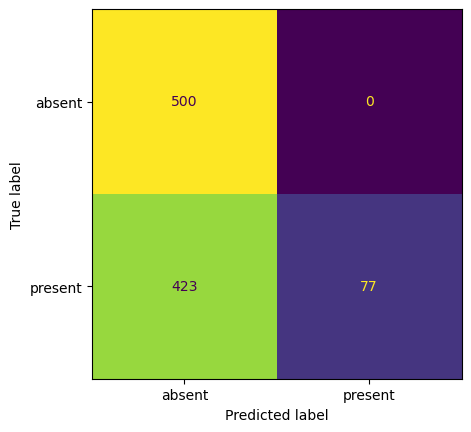

In [287]:
def model_to_cm(model, df):
    shuf_preds = model.predict(df)
    shuf_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(shuf_preds.target_presence.values))
    scores = shuf_preds.sigmoid_prediction.values
    targets = df.target_presence.values
    cm = opso.metrics.M.confusion_matrix(targets, scores.round())
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
    cm_display.plot(colorbar=False)
    return scores, targets

scores, targets = model_to_cm(model, shuffled_balanced_valid_df)


  0%|          | 0/1000 [00:00<?, ?it/s]

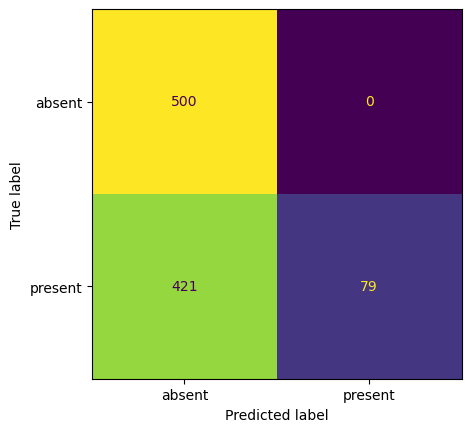

In [312]:
epoch_n_model = opso.cnn.load_model("epoch-16.model")
_, __ = model_to_cm(model, shuffled_balanced_valid_df)

Using only focal samples for the present class has the effect of increasing precision at the expense of recall. This is for a threshold of 0.5, so other thresholds should be tried. 

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 

In [283]:
cleaned_valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")
# Remove the 'discard' samples from the validation set
cleaned_valid_df.drop(cleaned_valid_df.loc[cleaned_valid_df.confidence_cat == 1].index, inplace=True)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10694 [00:00<?, ?it/s]

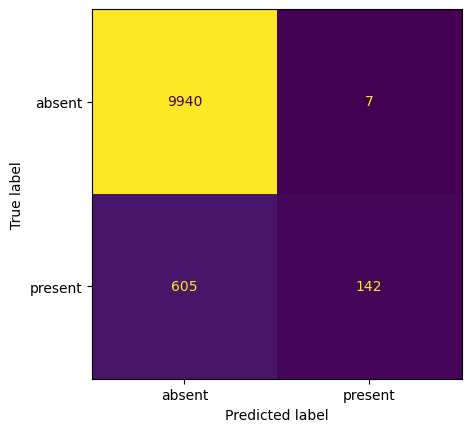

In [313]:
scores, targets = model_to_cm(model, cleaned_valid_df)

In [314]:
wandb.log({"validation.confusion_matrix" : wandb.plot.confusion_matrix(preds=scores.round(),
                        y_true=targets,
                        class_names=["absent", "present"])})

In [316]:
wandb.sklearn.plot_confusion_matrix(targets, scores.round(), ["absent", "present"])

# Look at the metrics across thresholds

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


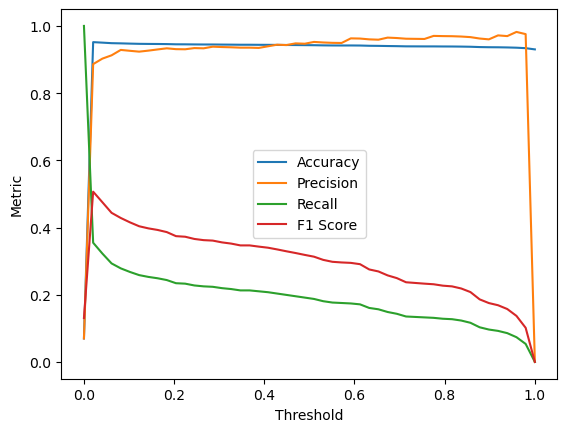

<Figure size 640x480 with 0 Axes>

In [317]:
vary_threshold_plot = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
vary_threshold_plot.savefig('vary_threshold_plot.png')
wandb.log({"vary_threshold_plot": wandb.Image('vary_threshold_plot.png')})

# Result: 

This training run increased precision at the expense of recall. There were numerous factors changed at once here though - so the change in precision can't be directly attributed to the focal samples. 

- the absent / present ratio was far more skewed than before: there are approximately 40 times more absent samples than present samples in this dataset - the 

# Save the best model

In [45]:
# best_model = opso.cnn.load_model("best.model")
# best_model.save(model_save_path / f"osfl_model_iter2_{dt}")

In [318]:

wandb.finish()


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▁▂
loss,█▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch,1
loss,0.00997


In [320]:
model.save(f"first_focal_unbalanced{dt}.model")